### Spice - Indication Network OR Spice - Phytochemical Network ###
#### Author: Shuchen Zhang

### Save adjacency mtx of the original projection graphs ###

### Backbone Extraction ###

In [1]:
import networkx as nx
import pandas as pd
import json
from itertools import chain
from Graph_Helpers import extract_backbone
import os
import matplotlib.pyplot as plt


In [2]:
FILE_IDX = 0  # 0 = spice2indic, 1 = spice2phyto
IDX = 0       # 0 = top_projection (spices), 1 = bot_projection (indications or phytos)

In [3]:
PROJ_MODE = ['projgraph_spice_2indic', 'projgraph_indic']
top_projection = nx.read_gpickle("../Data/top_projection_spice2indic.gpickle")
bot_projection = nx.read_gpickle("../Data/bot_projection_spice2indic.gpickle")
Spice_Indication_df = pd.read_excel("../Data/spice_indication_matrix_projgraph_spice_2indic.xlsx", index_col=0)

print("PROJ_MODE:", PROJ_MODE)

PROJ_MODE: ['projgraph_spice_2indic', 'projgraph_indic']


## backbone extraction


In [5]:
import os

if IDX == 0:
    ALPHA = 0.04 if FILE_IDX == 0 else 0.008
    top_backbone_nx = extract_backbone(top_projection, ALPHA)
    backbone_graph = top_backbone_nx
else:
    ALPHA = 0.00001
    bot_backbone_nx = extract_backbone(bot_projection, ALPHA)
    backbone_graph = bot_backbone_nx

print("Edge Count:", backbone_graph.number_of_edges())
print("Node Count:", backbone_graph.number_of_nodes())

# Create the data folder if it doesn't exist
os.makedirs("data", exist_ok=True)

adjmtx_pd = nx.to_pandas_adjacency(backbone_graph)
adjmtx_pd.to_excel(f"../Data/Derived_Data/adjmtx_{PROJ_MODE[IDX]}_{ALPHA}.xlsx")

print(f"Excel file saved to data/adjmtx_{PROJ_MODE[IDX]}_{ALPHA}.xlsx")

Edge Count: 114
Node Count: 93
Excel file saved to data/adjmtx_projgraph_spice_2indic_0.04.xlsx


### Generate clustering for backboned projection graph ###
Note: First generate clustering on entire projection graph, then generate assign the backbone nodes to their corresponding clusters

### Clustering 1: Wakita-Tusurumi Clustering ###

In [8]:
# Generate clustering for backbone, based on the whole graph clustering
import pandas as pd

# read {node: group number} from clustering on entire projection graph
cluster_pd = pd.read_excel('NODEXL_PLOT_NEW/'+ PROJ_MODE[0] + '/' + PROJ_MODE[IDX] + '_cluster2node_wakita.xlsx')
node2cluster_orig = dict(zip(list(cluster_pd['Vertex']), list(cluster_pd['Group'])))

# find group number (cluster) for backbone nodes
if IDX == 0:
    backbone_nodes = top_backbone_nx.nodes()
else:
    backbone_nodes = bot_backbone_nx.nodes()
cluster2node_backbone = {}
for node in backbone_nodes:
    cluster = node2cluster_orig[node]
    if not cluster in cluster2node_backbone:
        cluster2node_backbone[cluster] = [node]
    else:
        cluster2node_backbone[cluster].extend([node])
# generate clustering for backboned projection graph
cluster_list = []
for k,v in cluster2node_backbone.items():
    cluster_list.extend(len(v)*[k])
node_list = list(chain.from_iterable(cluster2node_backbone.values()))
cluster2node_backbone_df = pd.DataFrame({'Group': cluster_list, 'Vertex': node_list})
cluster2node_backbone_df.to_excel('../Data/Derived_Data/' + PROJ_MODE[0] + PROJ_MODE[IDX] + '_cluster2node_'+ str(ALPHA)+'_wakita.xlsx') #keep in code , data folder will only input files


## To analyze the clusters obtained

In [9]:
# add cluster column to Spice_Indication_df
def df_spice2indic_clustered(cluster_pd, Spice_Indication_df):
    print(len(cluster_pd.index))
    for i in range(len(cluster_pd.index)):
        spice = cluster_pd.loc[i, 'Vertex']
        cluster = cluster_pd.loc[i, 'Group']
        if 'G' not in cluster:
            print(spice)
        Spice_Indication_df.loc[spice, 'Cluster'] = cluster
    return Spice_Indication_df
spice2indic_clustered_wakita = df_spice2indic_clustered(cluster_pd, Spice_Indication_df)
spice2indic_clustered_wakita.head()

742


,Languor,Parasitemia,Lambliasis,Dementia,Myocardosis,Hypothyroidism,Menorrhagia,Hernia,Earache,"Cancer,wrist",...,IDDM,Nosebleed,Sore throat,Listeria,Sunstroke,Scurvy,Exocrine hepatic insufficiency,Bee sting,"Cancer,whitlow",Cluster
Acacia,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,G3
Adam's needles,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,G3
African caper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,G1
Agrimony,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,G2
Air plant,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,G4


### delete clusters with less than 20 spices(can be experimented)

In [10]:
def df_cluster2count(Spice_Indication_df):
    temp = Spice_Indication_df['Cluster'].value_counts() # find no of spices in each cluster
    print(temp)
    # delete cluster with less than 20 enteries
    # for each cluster, each indication receive score calculated by # associated spices in cluster / # spices in cluster 
    group_ind_count =Spice_Indication_df.groupby('Cluster').apply(lambda x: x.sum()/len(x))
    keepClust = temp.loc[temp>5].index
    delClust = set(temp.index ) - set(keepClust)
    group_ind_count.drop(delClust, inplace=True)
    return group_ind_count
cluster2count_wakita = df_cluster2count(spice2indic_clustered_wakita)
cluster2count_wakita

G1     201
G2     127
G3     122
G4      89
G5      80
G6      75
G7      35
G8       9
G9       2
G11      1
G10      1
Name: Cluster, dtype: int64


,Languor,Parasitemia,Lambliasis,Dementia,Myocardosis,Hypothyroidism,Menorrhagia,Hernia,Earache,"Cancer,wrist",...,Bunion,IDDM,Nosebleed,Sore throat,Listeria,Sunstroke,Scurvy,Exocrine hepatic insufficiency,Bee sting,"Cancer,whitlow"
Cluster,,,,,,,,,,,,,,,,,,,,,
G1,0.000000,0.004975,0.000000,0.029851,0.009950,0.009950,0.069652,0.024876,0.044776,0.000000,...,0.009950,0.004975,0.004975,0.233831,0.000000,0.000000,0.024876,0.000000,0.000000,0.000000
G2,0.000000,0.000000,0.000000,0.039370,0.015748,0.000000,0.086614,0.023622,0.125984,0.007874,...,0.031496,0.000000,0.000000,0.346457,0.007874,0.007874,0.055118,0.000000,0.000000,0.007874
G3,0.000000,0.000000,0.000000,0.008197,0.016393,0.000000,0.040984,0.016393,0.057377,0.000000,...,0.000000,0.000000,0.000000,0.204918,0.000000,0.000000,0.016393,0.000000,0.000000,0.000000
G4,0.000000,0.000000,0.000000,0.022472,0.011236,0.022472,0.044944,0.011236,0.101124,0.000000,...,0.000000,0.000000,0.000000,0.269663,0.000000,0.000000,0.078652,0.000000,0.000000,0.000000
G5,0.000000,0.000000,0.000000,0.012500,0.025000,0.012500,0.100000,0.050000,0.212500,0.012500,...,0.012500,0.000000,0.000000,0.475000,0.012500,0.012500,0.037500,0.000000,0.000000,0.000000
G6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106667,0.013333,0.066667,0.000000,...,0.000000,0.013333,0.000000,0.346667,0.000000,0.013333,0.053333,0.013333,0.013333,0.000000
G7,0.028571,0.000000,0.000000,0.000000,0.028571,0.000000,0.114286,0.085714,0.057143,0.000000,...,0.028571,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
G8,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,...,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
cluster2color = pd.read_excel('NODEXL_PLOT_NEW/' + PROJ_MODE[0] + '/'+ PROJ_MODE[0] + '_clustercolor.xlsx')
rgb_val = tuple([int(val) for val in cluster2color.loc[cluster2color['Group']=='G1','Vertex Color'].values[0].split(',')])
cluster2color

,Group,Vertex Color,Vertex Shape
0,G1,"0, 12, 96",Disk
1,G2,"0, 136, 227",Disk
2,G3,"0, 100, 50",Disk
3,G4,"0, 176, 22",Disk
4,G5,"191, 0, 0",Disk
5,G6,"230, 120, 0",Disk
6,G7,"255, 191, 0",Disk
7,G8,"150, 200, 0",Disk
8,G9,"200, 0, 120",Disk
9,G10,"77, 0, 96",Disk


(0.0, 0.047058823529411764, 0.3764705882352941)
(0.0, 0.5333333333333333, 0.8901960784313725)
(0.0, 0.39215686274509803, 0.19607843137254902)
(0.0, 0.6901960784313725, 0.08627450980392157)
(0.7490196078431373, 0.0, 0.0)
(0.9019607843137255, 0.47058823529411764, 0.0)
(1.0, 0.7490196078431373, 0.0)
(0.5882352941176471, 0.7843137254901961, 0.0)


/var/folders/b4/v914vnr53d78831b3prx5h680000gn/T/ipykernel_18217/2131070989.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  top_nodes = list (Spice_Indication_df.loc[temp].sum(axis=1).sort_values(ascending=False)[:2].index)
/var/folders/b4/v914vnr53d78831b3prx5h680000gn/T/ipykernel_18217/2131070989.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  top_nodes = list (Spice_Indication_df.loc[temp].sum(axis=1).sort_values(ascending=False)[:2].index)
/var/folders/b4/v914vnr53d78831b3prx5h680000gn/T/ipykernel_18217/2131070989.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a futu

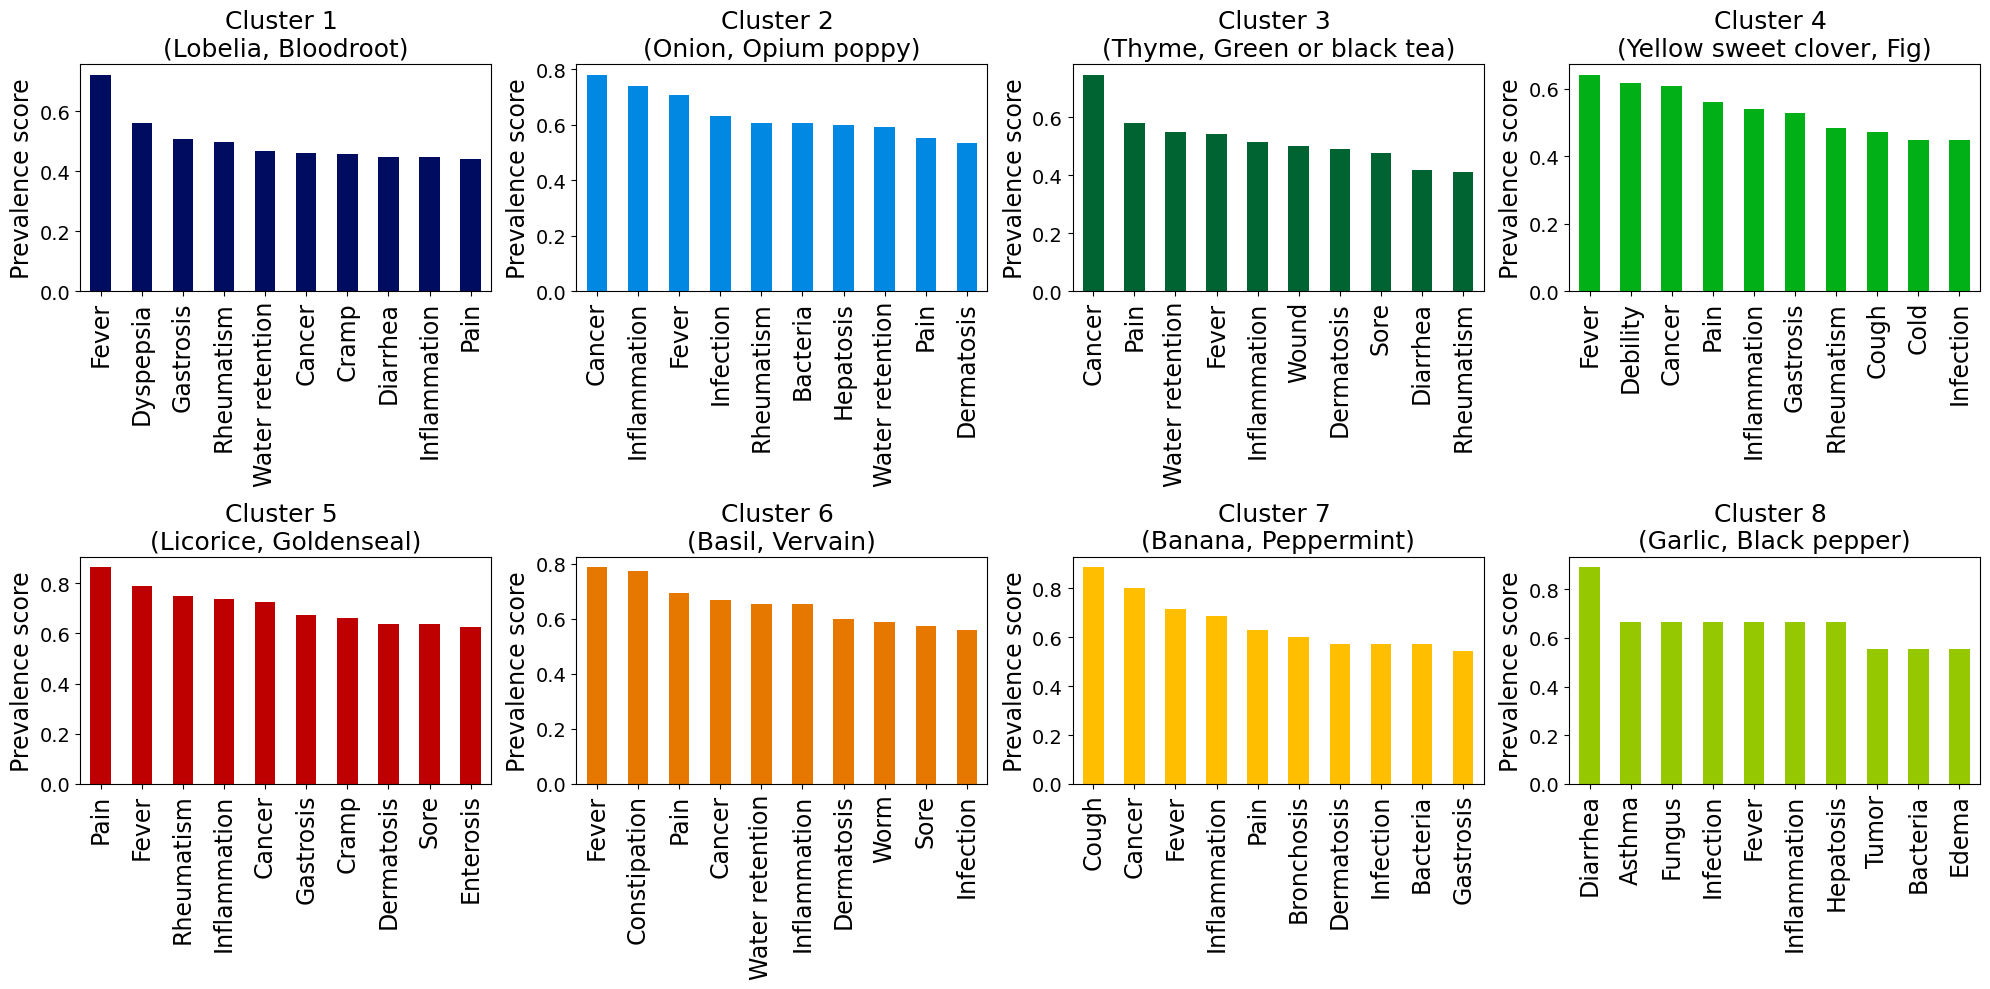

In [12]:
# find top diseses from each cluster
def plot_indic2count_bycluster(Spice_Indication_df,group_ind_count, save_path):
    fig = plt.figure(figsize= (20,10))
    fig.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.8)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)

    for i, ind in enumerate(group_ind_count.index):
        t = group_ind_count.loc[ind].sort_values(ascending = False)[:10] # find top spices
        #t = t[t>0.5]
        rgb_val = tuple([int(val)/255 for val in cluster2color.loc[cluster2color['Group']==ind,'Vertex Color'].values[0].split(',')])
        print(rgb_val)
        ax = fig.add_subplot(2,4,i+1)
        t.plot.bar(ax=ax, color=rgb_val)
        temp = Spice_Indication_df.loc[Spice_Indication_df['Cluster']==ind].index
        #list (Spice_Indication_df.loc[temp].sum(axis=1).sort_values(ascending=False)[:10].index)
        top_nodes = list (Spice_Indication_df.loc[temp].sum(axis=1).sort_values(ascending=False)[:2].index)
        plt.title('Cluster %s \n(%s, %s)'%(ind[1:],top_nodes[0],top_nodes[1]),fontsize=18)
        plt.ylabel('Prevalence score', fontsize=17)
        plt.xticks(fontsize=17)
    #plt.ylabel(r'\bf{phase field} $\phi$', {'color': 'C0', 'fontsize': 20})
    plt.tight_layout()
    plt.savefig(save_path)
save_path = "../Figures/distribution_wakita.png"
plot_indic2count_bycluster(spice2indic_clustered_wakita, cluster2count_wakita, save_path)